In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)

In [4]:
path.ls()

[PosixPath('/home/edwin/.fastai/data/camvid/images'),
 PosixPath('/home/edwin/.fastai/data/camvid/labels'),
 PosixPath('/home/edwin/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/edwin/.fastai/data/camvid/valid.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/edwin/.fastai/data/camvid/images/0016E5_04590.png'),
 PosixPath('/home/edwin/.fastai/data/camvid/images/0006R0_f03870.png'),
 PosixPath('/home/edwin/.fastai/data/camvid/images/0016E5_00480.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/edwin/.fastai/data/camvid/labels/0006R0_f02250_P.png'),
 PosixPath('/home/edwin/.fastai/data/camvid/labels/0001TP_008220_P.png'),
 PosixPath('/home/edwin/.fastai/data/camvid/labels/0016E5_07140_P.png')]

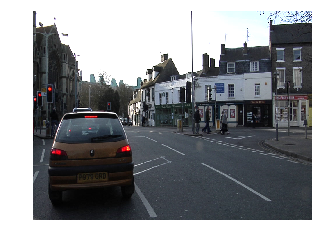

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

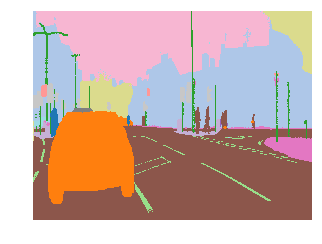

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
mask.shape, mask.data

(torch.Size([1, 720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
size = 224
bs = 4
data = (ImageFileList.from_folder(path_img)
        .label_from_func(get_y_fn)
        .split_by_fname_file('../valid.txt')
        .datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

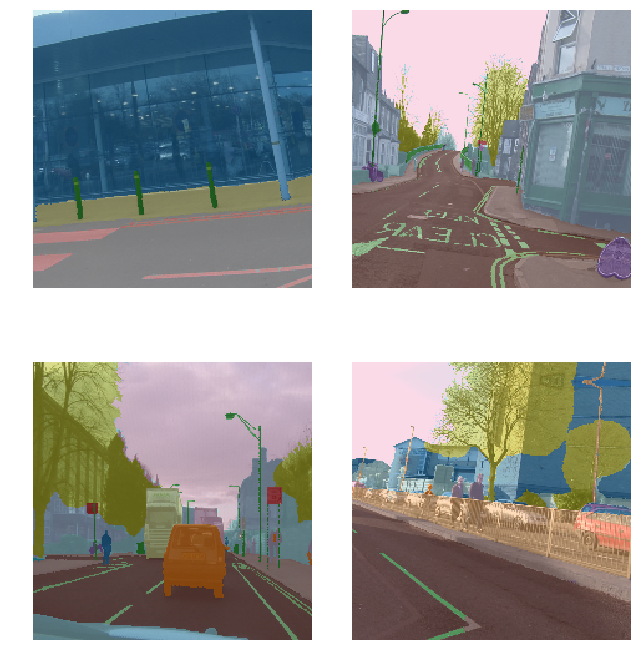

In [14]:
data.show_batch(2)

In [15]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze()
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
metrics=acc_camvid

In [17]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [18]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


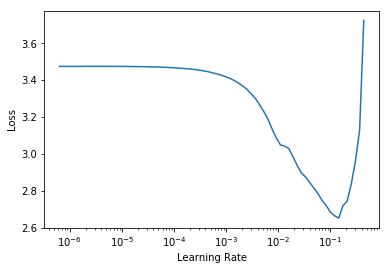

In [19]:
learn.recorder.plot()

In [20]:
lr = 1e-2

In [21]:
learn.fit_one_cycle(5, slice(lr))

Total time: 01:33
epoch  train_loss  valid_loss  acc_camvid
1      1.149308    2.719175    0.328829    (00:20)
2      1.032831    1.109582    0.639799    (00:18)
3      0.826037    0.714359    0.817496    (00:18)
4      0.701199    58.157948   0.833501    (00:18)
5      0.666419    159.284988  0.835174    (00:18)



In [22]:
learn.fit_one_cycle(5, slice(lr))

Total time: 01:31
epoch  train_loss  valid_loss  acc_camvid
1      0.717633    0.976108    0.770555    (00:18)
2      0.716426    0.759948    0.821470    (00:18)
3      0.672304    0.601315    0.841944    (00:18)
4      0.629260    0.558092    0.849640    (00:18)
5      0.572628    0.514817    0.859763    (00:18)



In [23]:
learn.save('camvid-stage-1.pth')

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


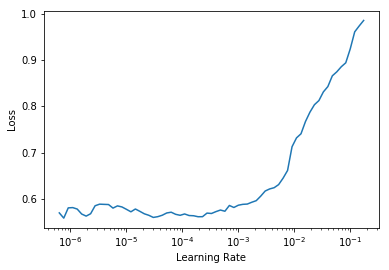

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(12, slice(1e-5, lr/5))

Total time: 04:50
epoch  train_loss  valid_loss  acc_camvid
1      0.566353    0.503140    0.860862    (00:24)
2      0.556884    0.517240    0.855000    (00:24)
3      0.552541    0.540801    0.856666    (00:24)
4      0.570719    0.590968    0.856001    (00:24)
5      0.555587    0.505105    0.859926    (00:24)
6      0.542637    0.484311    0.864209    (00:24)
7      0.513630    0.487053    0.857020    (00:24)
8      0.504448    0.462428    0.866171    (00:24)
9      0.491137    0.437236    0.871606    (00:24)
10     0.488903    0.450284    0.870619    (00:24)
11     0.487512    0.442226    0.871329    (00:24)
12     0.473114    0.442176    0.871904    (00:24)



In [28]:
learn.save('stage-3-camvid.pth')